# Tensorflow
Pozn.: v tomto textu vycházím (místy dokonce kód přejímám) z Deep learning v jazyku Python od F. Cholleta.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.optimizers import RMSprop
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.models import load_model

Tenzory v Tensorflow vytvoříme pomocí funkce *constant*, které podhodíme v případě 1D tenzoru list. Všimněme si, že defaultním datovým typem v případě integerů na vstupu je 32-bitový integer. Pokud bychom potřebovali float, musíme k číslů přidat desetinné tečky a za nimi jednu nulu.

In [2]:
tensor_1d = tf.constant([1, 2, 3])
print(tensor_1d)
tensor_1d_float = tf.constant([1.0, 2.0, 3.0])
print(tensor_1d_float)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)


Pro vytvoření 2D tenzoru do funkce *constant* vložíme list listů. Pro více rozměrů pokračuje vnořování listů v podobném duchu.

In [3]:
tensor_2d = tf.constant([
    [1, 2, 3],
    [4, 5, 6]
])
print(tensor_2d)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)


Narozdíl od Pytorche jsou tenzory v Tensorflow immutable, tj. po jejich vytvoření je už nemůžeme měnit:

In [4]:
tensor_1d = tf.constant([1, 2, 3])
print(tensor_1d[2])
tensor_1d[2]=30

tf.Tensor(3, shape=(), dtype=int32)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

Jelikož jsou neuronové sítě založené na změnách vah reprezentovaných tensory, musí existovat měnitelný tensorový objekt. Jedná se o instance třídy *Variable*, kterým neměnný tensor podohodíme do konstruktoru jako *initial_value*.

In [6]:
some_variable = tf.Variable(initial_value=tensor_1d)
some_variable

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3])>

Proměnnou změníme s pomocí metody *assign*. Do té musíme vložit tensor o stejném rozměru, který měl tensor původní. V opačném případě se setkáme s chybovou hláškou 
```
ValueError: Cannot assign value to variable ' Variable:0': Shape mismatch.The variable shape (3,), and the assigned value shape () are incompatible.
```

In [9]:
some_variable.assign([4,5,6])
some_variable

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([4, 5, 6])>

Pokud chceme změnit jen jednu hodnotu (či obecně výsek hodnot), použijeme identifikaci indexy a *assign* metodu až posléze.

Bacha - pokud bychom se pokusili o "přímé" nastavení hodnoty (ala "some_variable[2] = 60"), dostali bychom chybu
```
TypeError: 'ResourceVariable' object does not support item assignment
```

In [12]:
some_variable[2].assign(60)
some_variable

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([ 4,  5, 60])>

Pro přičtení či odečtení bychom do assignu mohli dávat kód nesoucí se ve stylu "some_variable + [10,10,10]". Nicméně asi přehlednější budou metody *assign_add" a "assign_sub* fungující podobně jako += a -=.

In [14]:
some_variable.assign_add([10,10,10])
some_variable

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([14, 15, 70])>

In [15]:
some_variable.assign_sub([10,10,10])
some_variable

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([ 4,  5, 60])>

Dalším rozdílem mezi Pytorchem a Tensorflowem je skutečnost, že v Tensorflowu mohou tenzory obsahovat i textové řetězce:

In [18]:
tensor_text = tf.constant(["one", "two", "three"])
print(tensor_text)

tf.Tensor([b'one' b'two' b'three'], shape=(3,), dtype=string)


Nepravidelné (pilovité) tvary jsou ale zakázány i v Tensorflowu. Následující kód by vedl k hlášce "ValueError: Can't convert non-rectangular Python sequence to Tensor.".
```python
tensor_bad = tf.constant([
    [1, 2],
    [3],
    [5, 6]
])
```

Pro zjištění velikosti dimezí se použije atribut *shape*. 

In [20]:
tensor_2d = tf.constant([
    [1, 2, 3],
    [4, 5, 6]
])
print(tensor_2d.shape)

(2, 3)


Pro zjištění *počtu* dimenzí lze zase sáhnout po atributu *ndim*:

In [21]:
print(tensor_2d.ndim)

2


Datový typ získáme skrze atribut *dtype*.

In [22]:
print(tensor_2d.dtype)

<dtype: 'int32'>


Získání celkového počtu elementů bychom díky pravidelnému tvaru získali přenásobením velikostí dimenzí. Nicméně takové operace nebude potřeba, neboť na celkový počet elementů máme dedikovanou funkci (nikoli metodu tenzoru, nýbrž opravdu samostatnou funkci!) *size*:

In [23]:
tf.size(tensor_2d)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

Pro ukázku matematických operací mezi tenzory si dva exempláře připravme.

In [24]:
first_tensor = tf.constant([
    [1,1,1],
    [2,2,2],
    [3,3,3]
])
second_tensor = tf.constant([
    [10,1,0],
    [0,10,1],
    [-1,-1,-1]
])

Operace mezi tenzorem a číslem jsou přímočaré.

In [25]:
first_tensor/3

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[0.33333333, 0.33333333, 0.33333333],
       [0.66666667, 0.66666667, 0.66666667],
       [1.        , 1.        , 1.        ]])>

"Element-wise" operace mezi dvěma tenzory lze provést s pomocí stejných operátorů jako v Pytorchi.

In [26]:
first_tensor-second_tensor

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[-9,  0,  1],
       [ 2, -8,  1],
       [ 4,  4,  4]])>

In [27]:
first_tensor*second_tensor

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[10,  1,  0],
       [ 0, 20,  2],
       [-3, -3, -3]])>

Pro skalární součin sáhneme po zavináči:

In [28]:
first_tensor@second_tensor

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 9, 10,  0],
       [18, 20,  0],
       [27, 30,  0]])>

Pokud chceme explicitně použít funkce, tak pro násobení mezi jednotlivými elementy tenzorů aplikujeme *multiply* (v Pytorchi *mul*) a pro maticové násobení *matmul* (stejné jméno jako v Pytorchi).

In [29]:
tf.multiply(first_tensor, second_tensor)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[10,  1,  0],
       [ 0, 20,  2],
       [-3, -3, -3]])>

In [30]:
tf.matmul(first_tensor, second_tensor)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 9, 10,  0],
       [18, 20,  0],
       [27, 30,  0]])>

Na porovnání elemetů tenzoru se použijí dvojená rovnítka.

In [31]:
first_tensor == second_tensor

<tf.Tensor: shape=(3, 3), dtype=bool, numpy=
array([[False,  True, False],
       [False, False, False],
       [False, False, False]])>

Převod tenzoru na numpy array zajistí vložení tenzoru do odpovídajícího konstruktoru.

In [32]:
np.array(first_tensor)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

Pro získání gradientu funkce vypuštěné na tensor se použije *GradientTape*. Všechny operace se musí uskutečnit v jejím kontextovém bloku, gradienty následně získáme z *gradient* metody objektu *tape* (onen blok reprezentující), do které vložíme jednak výsledek operace, jednak vstupní tensor (vstupní proměnnou).

Bacha - očekává se, že vstupem budou floaty - pokud by se list v konstruktoru *Variable* skládal z integerů, uložilo by se do proměnné *gradient* None. Takto vidíme, že se koeficient z derivace (3*2) správně vynásobil s hodnotami vstupního vektoru. 

In [36]:
original_tensor = tf.Variable(initial_value=[3.,10.,5.])
with tf.GradientTape() as tape:
    intermediate_result = tf.square(original_tensor)
    final_result = 3*intermediate_result

gradient = tape.gradient(final_result, original_tensor)
gradient

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([18., 60., 30.], dtype=float32)>

## Binární klasifikace

V následujících příkladech si stáhneme předpřipravená data. Budeme s nimi sice muset udělat pár základních úprav, s prací se surovými daty se to ale nedá srovnávat.  
Předpřipravené datasety získáme s pomocí funkcí z *tensorflow.keras.datasets*. Závorky u výstupů jsou opravdu potřeba - jinak bychom dostali chybu "ValueError: not enough values to unpack (expected 4, got 2)". Parametr *num_words* značí, že chceme jen X nejzastoupenějších slov z korpusu.

In [2]:
from tensorflow.keras.datasets import imdb
num_wanted_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_wanted_words)

Labely obsahují flag o sentimentu recenze z imdb - 0 značí negativní recenzi, 1 recenzi pozitivní.

In [3]:
train_labels[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

Trénovací data se skládají z listu integerů o proměnlivé délce. Každé číslo totiž reprezentuje index slova, které bylo v recenzi použito.

In [3]:
train_data[0][0:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [4]:
print(
    len(train_data[0]),
    len(train_data[1])
)

218 189


Data převedeme na vektor s délkou celého slovníku, kde jedničky na k-tém místě reprezentují přítomnost slova o indexu k.

In [5]:
type(train_data)

numpy.ndarray

In [62]:
def vectorize_sequence(semitransformed_reviews_array:np.ndarray, dimension:int=num_wanted_words):
    transformed_reviews_array = np.zeros(
        (
        len(semitransformed_reviews_array), 
        dimension
        )
    )
    for one_review_index, one_review in enumerate(semitransformed_reviews_array):
        for one_word_number in one_review:
            transformed_reviews_array[one_review_index,one_word_number] = 1
    return transformed_reviews_array

In [ ]:
x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

In [7]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Labely převedeme z integerů na floaty.

In [8]:
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

Model vytvoříme s pomocí *Sequentials* objektu, do kterého vložíme několik *Dense* vrstev. Číslo v prvním parametru představuje počet výstupů z vrstvy, parametr *activation* očekává aktivační funkci, zde v podobě stringového názvu (bez aktivační funkce by se celá neuronová síť dala nahradit logistickou regresí). 

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

Výše jsme si zadefinovali architekturu modelu, nicméně model fakticky vytvoříme až příkazem *compile*. Do této metody vložíme *optimizer* - způsob, jakým se bude Keras snažit dosáhnout minimální ztrátové funkce. Dále musíme zadat samotnou ztrátovou funkci - to do parametru *loss*. Nakonec zadáme metriky, které chceme při validaci sledovat. Tyto metriky se nepoužívají při optimalizaci vah - na to slouží ztrátová funkce. Metriky tak nejsou určené pro algoritmus, ale jen pro nás. Díky tomu sem můžeme dát i věci, které by se obtížně derivovaly, např. AUC.

In [30]:
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

Z trénovací sady vydělíme sadu validační (jednoduchým použitím indexů, což znamená, že předpokládáme, že data už byly zamíchaná).

In [31]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Validační data vložíme do *fit* metody modelu, konrkétně do parametru *validation_data*. Díky tomu se budou při trénování sledovat metriky nejen pro trénovací data, ale právě i pro data validační. Do *fit* vložíme pochopitelně i trénovací data. Též specifikujeme velikost dávky (*batch_size*) alias množství dat, které má optimalizér v jeden okamžik k dispozici. Nakonec specifikujeme i počet *epoch*, tj. informaci o tom, kolikrát má model projet celá trénovací data.

In [32]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val,y_val)
)

Epoch 1/20
30/30 [==============================] - 2s 51ms/step - loss: 0.4988 - binary_accuracy: 0.7924 - precision_4: 0.8044 - recall_4: 0.7688 - auc_4: 0.8809 - val_loss: 0.3718 - val_binary_accuracy: 0.8728 - val_precision_4: 0.8580 - val_recall_4: 0.8967 - val_auc_4: 0.9419
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2943 - binary_accuracy: 0.9038 - precision_4: 0.8993 - recall_4: 0.9079 - auc_4: 0.9631 - val_loss: 0.3146 - val_binary_accuracy: 0.8771 - val_precision_4: 0.9223 - val_recall_4: 0.8264 - val_auc_4: 0.9511
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2157 - binary_accuracy: 0.9297 - precision_4: 0.9261 - recall_4: 0.9327 - auc_4: 0.9788 - val_loss: 0.2778 - val_binary_accuracy: 0.8912 - val_precision_4: 0.8891 - val_recall_4: 0.8965 - val_auc_4: 0.9546
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1718 - binary_accuracy: 0.9440 - precision_4: 0.9408 - recall_4: 0.9468 - auc_4: 0

Vidíme, že v history objektu jsou opravdu všechny metriky pro trénovací i validační data a to pro každou epochu.

In [35]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'precision_4', 'recall_4', 'auc_4', 'val_loss', 'val_binary_accuracy', 'val_precision_4', 'val_recall_4', 'val_auc_4'])

Když si vykreslíme ztrátu i accuracy, vidíme, že se obě cca od čtvrté epochy kazí.

In [14]:
import matplotlib.pyplot as plt

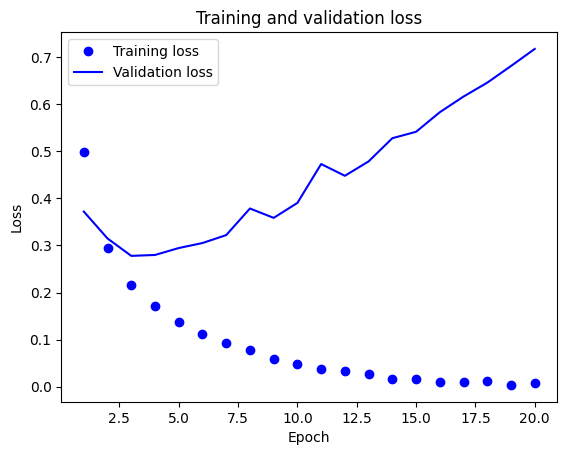

In [33]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

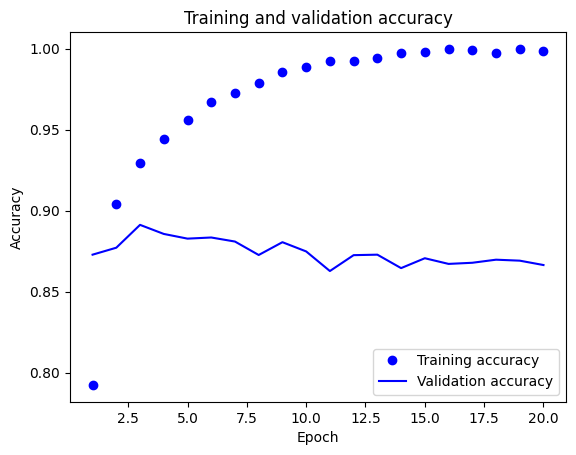

In [36]:
history_dict = history.history
train_accuracy = history_dict["binary_accuracy"]
val_accuracy = history_dict["val_binary_accuracy"]
epochs = range(1, len(train_accuracy)+1)

plt.plot(epochs, train_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Model tedy vyrobíme znova, tentokrát jen s čtyřmi epochami. Jelikož už validaci nepotřebujeme, použijeme pro trénování všechna data. Taktéž už není potřeba history objekt.

In [37]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=512
)

Epoch 1/4
49/49 [==============================] - 2s 15ms/step - loss: 0.4374 - binary_accuracy: 0.8230 - precision_5: 0.8492 - recall_5: 0.7855 - auc_5: 0.9089
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2516 - binary_accuracy: 0.9124 - precision_5: 0.9081 - recall_5: 0.9178 - auc_5: 0.9676
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.1966 - binary_accuracy: 0.9306 - precision_5: 0.9274 - recall_5: 0.9345 - auc_5: 0.9784
Epoch 4/4
49/49 [==============================] - 1s 13ms/step - loss: 0.1647 - binary_accuracy: 0.9413 - precision_5: 0.9388 - recall_5: 0.9442 - auc_5: 0.9846


Pro metriky na testovacích datech provoláme na natrénovaném modelu metodu *evaluate*.

In [38]:
result = model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.2963 - binary_accuracy: 0.8822 - precision_5: 0.8808 - recall_5: 0.8841 - auc_5: 0.9484


Pro predikování na datech použijeme metodu *predict*:

In [39]:
model.predict(x_test)[0]

782/782 [==============================] - 1s 2ms/step


array([0.19706404], dtype=float32)

## Multiclass klasifikace

Data získáme z datasetu reuters. Strukturu mají stejnou jako imdb, jen v labelech nejsou nuly a jedničky, nýbrž je tříd mnohem víc.

In [2]:
from tensorflow.keras.datasets import reuters
num_wanted_words = 10_000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_wanted_words)

In [3]:
train_labels[0:10]

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16], dtype=int64)

In [4]:
print(
    min(train_labels),
    max(train_labels)
)

0 45


Stejně jako v předchozí úloze upravíme trénovací a testovací data (myšleno featury, nikoli labely)

In [5]:
def vectorize_sequence(semitransformed_reviews_array:np.ndarray, dimension:int=num_wanted_words):
    transformed_reviews_array = np.zeros(
        (
        len(semitransformed_reviews_array), 
        dimension
        )
    )
    for one_review_index, one_review in enumerate(semitransformed_reviews_array):
        for one_word_number in one_review:
            transformed_reviews_array[one_review_index,one_word_number] = 1
    return transformed_reviews_array

In [6]:
x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

Narozdíl od sklearnu si Keras s takto vypadajícími labely sám o sobě neporadí, tj. musíme ručně docílit one-hot encodingu.

In [7]:
def transform_to_one_hot(labels:np.ndarray, dimension:int=46):
    number_of_records = len(labels)
    one_hot_array = np.zeros(
        (number_of_records, dimension)
    )
    for record_index, record_class_number in enumerate(labels):
        one_hot_array[record_index, record_class_number] = 1
    return one_hot_array

y_train = transform_to_one_hot(train_labels)
y_test = transform_to_one_hot(test_labels)

Architektura modelu musí reflektovat, že máme 46 tříd.

In [23]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="sigmoid"),
])

Zkompilujeme model, přičemž tentorkát použijeme pro specifikování optimizéru a ztráty odpovídající objekty, nikoli jejich stringová jména.

In [24]:
from keras.metrics import CategoricalAccuracy
from keras.optimizers import RMSprop
from keras.losses import CategoricalCrossentropy

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

Narozdíl od předchozího příkladu si nebudeme validační set tvořit ručně sami, ale využijeme možnosti zadat do fitovací funkce parametr *validation_split*. Číslo v něm uložené říká, jaká část trénovacích dat má být uložena bokem pro validaci.

In [25]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1
)

Epoch 1/20
16/16 [==============================] - 1s 31ms/step - loss: 2.5725 - categorical_accuracy: 0.5174 - val_loss: 1.8482 - val_categorical_accuracy: 0.6307
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 1.4076 - categorical_accuracy: 0.7039 - val_loss: 1.4043 - val_categorical_accuracy: 0.7208
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.0225 - categorical_accuracy: 0.7854 - val_loss: 1.2049 - val_categorical_accuracy: 0.7364
Epoch 4/20
16/16 [==============================] - 0s 13ms/step - loss: 0.7958 - categorical_accuracy: 0.8332 - val_loss: 1.1095 - val_categorical_accuracy: 0.7531
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6375 - categorical_accuracy: 0.8676 - val_loss: 1.0401 - val_categorical_accuracy: 0.7742
Epoch 6/20
16/16 [==============================] - 0s 13ms/step - loss: 0.5129 - categorical_accuracy: 0.8981 - val_loss: 1.0111 - val_categorical_accuracy: 0.7798
Epoch 7/20

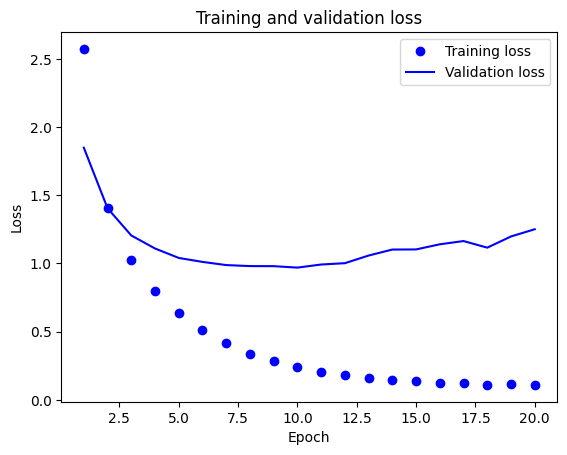

In [27]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

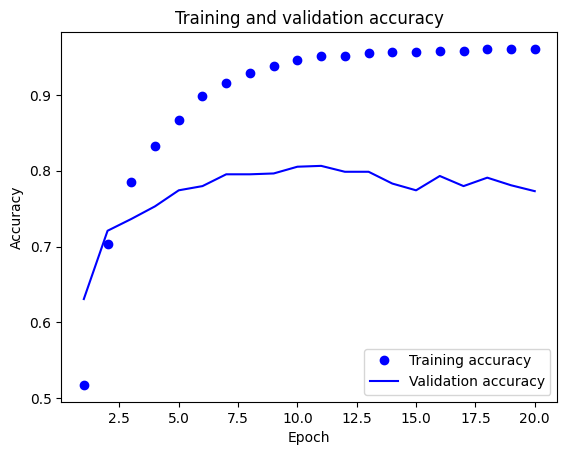

In [28]:
history_dict = history.history
train_accuracy = history_dict["categorical_accuracy"]
val_accuracy = history_dict["val_categorical_accuracy"]
epochs = range(1, len(train_accuracy)+1)

plt.plot(epochs, train_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Tentokrát je optimální počet epoch 9.

In [30]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="sigmoid"),
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512
)
print("\nEvaluation:")
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 14ms/step - loss: 2.3102 - categorical_accuracy: 0.5563
Epoch 2/9
18/18 [==============================] - 0s 9ms/step - loss: 1.2904 - categorical_accuracy: 0.7190
Epoch 3/9
18/18 [==============================] - 0s 10ms/step - loss: 0.9840 - categorical_accuracy: 0.7833
Epoch 4/9
18/18 [==============================] - 0s 11ms/step - loss: 0.7736 - categorical_accuracy: 0.8353
Epoch 5/9
18/18 [==============================] - 0s 11ms/step - loss: 0.6082 - categorical_accuracy: 0.8725
Epoch 6/9
18/18 [==============================] - 0s 11ms/step - loss: 0.4835 - categorical_accuracy: 0.8987
Epoch 7/9
18/18 [==============================] - 0s 10ms/step - loss: 0.3932 - categorical_accuracy: 0.9173
Epoch 8/9
18/18 [==============================] - 0s 10ms/step - loss: 0.3169 - categorical_accuracy: 0.9321
Epoch 9/9
18/18 [==============================] - 0s 9ms/step - loss: 0.2657 - categorical_accuracy: 0.9397

Evaluation:

Predikce pro konkrétní záznam vrací pravděpodobnosti, že onen záznam patří do jednotlivých tříd. Index třídy s největší pravděpodobností získáme s pomocí funkce *argmax*. Zde vidíme třídu s indexem 3, tj. čtvrtou třídu.

In [31]:
predictions = model.predict(x_test)
predictions[0]

71/71 [==============================] - 0s 2ms/step


array([8.3763964e-02, 1.9728145e-02, 9.9926838e-04, 9.9498284e-01,
       9.8273152e-01, 5.0012926e-03, 4.0150754e-02, 1.6929327e-02,
       5.5495912e-01, 5.0430163e-03, 3.7319552e-02, 1.9128680e-01,
       7.7282816e-02, 2.8937635e-01, 5.5351807e-03, 5.8209361e-03,
       3.5418794e-01, 1.1323322e-01, 5.3417198e-02, 4.6794623e-01,
       3.7798905e-01, 1.5960233e-01, 1.1187242e-02, 6.0523804e-02,
       2.2164236e-03, 2.2637554e-02, 5.4282718e-04, 5.0235134e-02,
       7.2176315e-02, 2.5244039e-02, 4.1572358e-02, 4.5352641e-02,
       2.2410968e-02, 2.5000699e-02, 2.2011069e-03, 3.4719261e-03,
       7.1229249e-02, 3.1901464e-02, 3.4213606e-03, 3.0719396e-01,
       1.1166827e-02, 4.1027565e-02, 1.3333463e-02, 5.8359560e-03,
       3.6250323e-02, 7.0123733e-03], dtype=float32)

In [32]:
np.argmax(predictions[0])

3

Pozn.: labely bychom mohli nechat tak, jak byly. V takovém případě bychom ale museli použít sparse varianty ztrátové funkce a accuracy.

In [38]:
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="sigmoid"),
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

model.fit(
    x_train,
    train_labels,
    epochs=9,
    batch_size=512
)
print("\nEvaluation:")
results = model.evaluate(x_test, test_labels)

Epoch 1/9
18/18 [==============================] - 1s 12ms/step - loss: 2.6068 - sparse_categorical_accuracy: 0.5418
Epoch 2/9
18/18 [==============================] - 0s 9ms/step - loss: 1.3924 - sparse_categorical_accuracy: 0.7067
Epoch 3/9
18/18 [==============================] - 0s 9ms/step - loss: 1.0317 - sparse_categorical_accuracy: 0.7768
Epoch 4/9
18/18 [==============================] - 0s 11ms/step - loss: 0.8047 - sparse_categorical_accuracy: 0.8268
Epoch 5/9
18/18 [==============================] - 0s 9ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.8625
Epoch 6/9
18/18 [==============================] - 0s 9ms/step - loss: 0.5092 - sparse_categorical_accuracy: 0.8901
Epoch 7/9
18/18 [==============================] - 0s 10ms/step - loss: 0.4068 - sparse_categorical_accuracy: 0.9108
Epoch 8/9
18/18 [==============================] - 0s 11ms/step - loss: 0.3327 - sparse_categorical_accuracy: 0.9272
Epoch 9/9
18/18 [==============================] - 0s 7ms/step - los

## Regrese

Pro ukázku regrese použijeme dataset o nemovitostech v Bostonu.

In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Všimněme si, že data jsou opravdu mrňavá - v trénovací sadě máme jen cca 400 záznamů.

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

Labely obsahují ceny nemovitostí v tisících dolarů.

In [5]:
train_targets[0:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

Neuronové sítě se při trénování dostávají do problémů, pakliže mají jednotlivé featury nesouměřitelné velikosti. Proto musíme provést škálování, tj. předpokládáme normální rozdělení a tak od trénovacích dat odečteme průměr a výsledek pak vydělíme standardní odchylkou. Je třeba si uvědomit, že u testovacích dat musíme použít průměr a odchylku vypočtenou z trénovacích dat.

In [6]:
train_mean = train_data.mean(axis=0)
train_data = train_data - train_mean
train_std = train_data.std(axis=0)
train_data = train_data/train_std

test_data = test_data - train_mean
test_data = test_data/train_std

Z důvodů, které mi zatím unikají, jsem při použití ztrátové funkce v nestringové objektové podobě dostal při fitování chybu "No gradients provided for any variable". Tudíž do ztráty raději vkládám "mse".

In [7]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=RMSprop(),
        loss="mse", metrics=["mae"]
    )
    return model

Mohli bychom si vytvořit klasickou validační sadu. Jenomže vzhledem k tomu, že máme málo záznamů, váha každého záznamu by prudce narostla. Tudíž by se metriky mohly dosti odlišovat podle toho, jaké záznamy do validační sady zrovna spadly. Proto použijeme k-fold crossvalidation. To znamená, že si trénovací data rozdělíme na K částí. Nejprve natrénujeme model na prvních K-1 částech a zvalidujeme na K-té části. Žolík trénovací sady bude v dalších iteracích přecházet na další části. Ve vsýledku tak budeme mít pro každou metriku K čísel, které můžeme zprůměrovat. 

In [9]:
folds_count = 4
num_val_samples = len(train_data)//folds_count
num_epochs = 500
all_mae_histories = []

for fold_index in range(folds_count):
    print(f"Processing fold {fold_index}")
    val_data = train_data[fold_index*num_val_samples : (fold_index+1)*num_val_samples]
    val_targets = train_targets[fold_index*num_val_samples : (fold_index+1)*num_val_samples]

    partial_train_data = np.concatenate(
        [
            train_data[: fold_index*num_val_samples],
            train_data[(fold_index+1)*num_val_samples:]
        ],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[: fold_index*num_val_samples],
            train_targets[(fold_index+1)*num_val_samples:]
        ],
        axis=0
    )

    model = build_model()

    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0
    )
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


Nyní metriky pro jednotlivé epochy zprůměrujeme a vykreslíme do grafu.

In [10]:
average_mae_history = []
for epoch_index in range(num_epochs):
    average_mae = np.mean([one_fold_history[epoch_index] for one_fold_history in all_mae_histories])
    average_mae_history.append(average_mae)

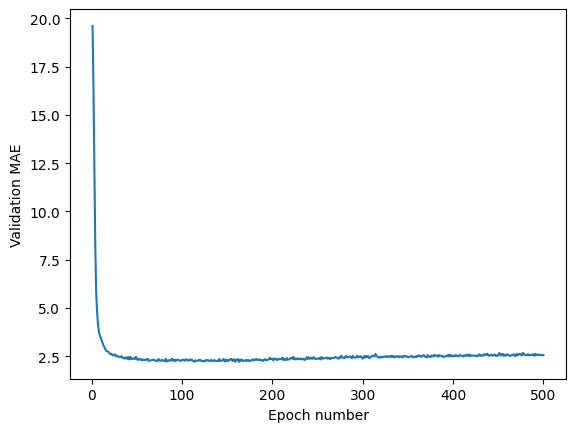

In [11]:
plt.plot(range(1, num_epochs + 1), average_mae_history)
plt.xlabel("Epoch number")
plt.ylabel("Validation MAE");

Usekneme začátek grafu, abychom něco viděli. Z nového borázku je jasné, že stačí cca 100 epoch a další už jsou kontraproduktivní.

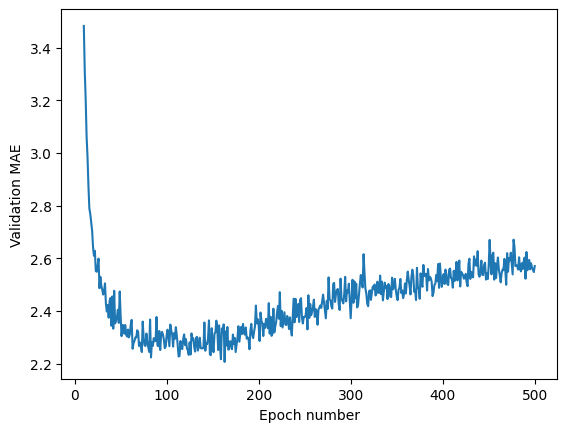

In [16]:
plt.plot(range(10, num_epochs + 1), average_mae_history[9:])
plt.xlabel("Epoch number")
plt.ylabel("Validation MAE");

Nakonec znova provedeme natrénování na celých trénovacích datech a spočítáme si metriky na datech testovacích.

In [17]:
model = build_model()
model.fit(train_data, train_targets, epochs=100, batch_size=16, verbose=False)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.6522 - mae: 2.5623


### Regularizace modelu
Pakliže se model naučí až příliš dobře trénovací data, má to neblahý vliv na predikce na validační (a následně i na testovací) sadě. Postupy vedoucí k redukci tohoto jevu označujeme jako regularizace.  
V kontextu obyčejných neuronových sítí máme tři základní regularizační přístupy:  
- zmenšení sítě  
- regularizace vah  
- dropout  

Regularizaci si předvedeme na imdb datasetu.

In [2]:
from tensorflow.keras.datasets import imdb
num_wanted_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_wanted_words)

def vectorize_sequence(semitransformed_reviews_array:np.ndarray, dimension:int=num_wanted_words):
    transformed_reviews_array = np.zeros(
        (
        len(semitransformed_reviews_array), 
        dimension
        )
    )
    for one_review_index, one_review in enumerate(semitransformed_reviews_array):
        for one_word_number in one_review:
            transformed_reviews_array[one_review_index,one_word_number] = 1
    return transformed_reviews_array

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

Napřed jako referenční model vytvoříme stejnou architekturu, s jakou jsme už pracovali výše.

In [4]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

from keras.losses import BinaryCrossentropy

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

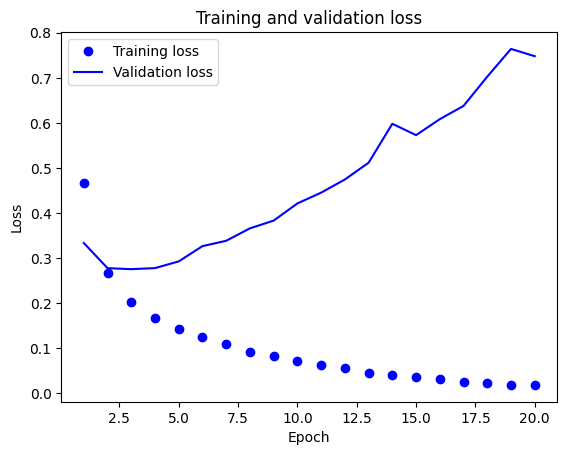

In [6]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Nyní zmenšíme počet neurovnů ve vrstvách sítě. Z výsledku je vidět, že validace nikdy nedosáhla optimální velikosti, ale zase mnohem déle vydržela v platu. Pro počet neuronů rovný 4 vypadal výsledek stejně jako výše pro 16 neuronů. Obecně neexistuje žádná všeobecně platná heuristika ohledně toho, jaká velikost by byla optimální.

In [4]:
model_small_size = keras.Sequential([
    layers.Dense(2, activation="relu"),
    layers.Dense(2, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

model_small_size.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model_small_size.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

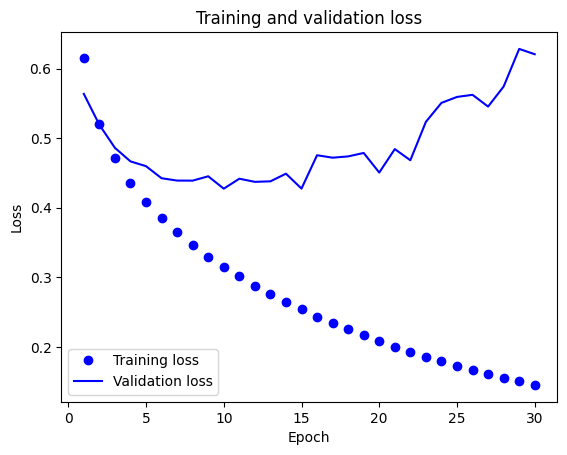

In [5]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Pro příliš velký model bude naopak validační ztráta extrémně velká.

In [6]:
model_large_size = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

model_large_size.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model_large_size.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

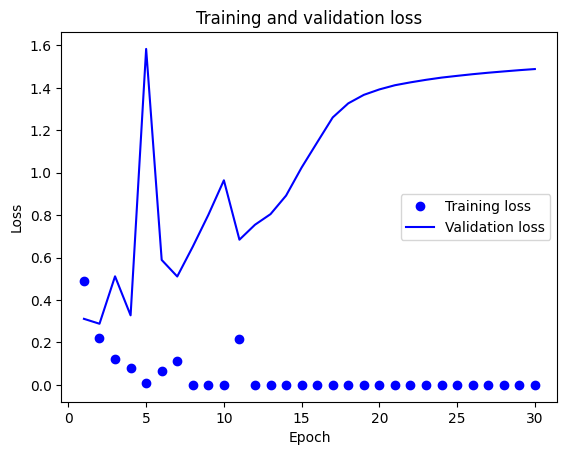

In [7]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Druhý regularizační přístup spočívá v regularizaci vah. Principielně jde o to, že se k celkové ztrátové funkci přičte penalizační člen skládající se z nějaké uživatelem určené konstanty a jednotlivých vah. Díky tomu musí váhy nabývat menších hodnot a rozdělení hodnot vah se stane pravidelnějším.  
Pokud chceme použít regularizace vah, přidáme do *Dense* vrstev parametr *kernel_regularizer*. Do něj vložíme některý z typů regularizace. Níže ukazujeme l2, možné jsou ale i l1 či l1_l2 (číslo v závorkách udává míru penalizace).  
V tomto příkladu vedla l2 regularizace k zploštění závislosti ztrátové funkce. Nicméně obvykle bývají neuronové sítě tak přeparametrizované, že tento přístup mnoho nedělá.

In [6]:
from tensorflow.keras import regularizers

model_kernel_reg = keras.Sequential([
    layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(1, activation="sigmoid"),
])

from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras.losses import BinaryCrossentropy
from keras.optimizers import RMSprop


model_kernel_reg.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model_kernel_reg.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

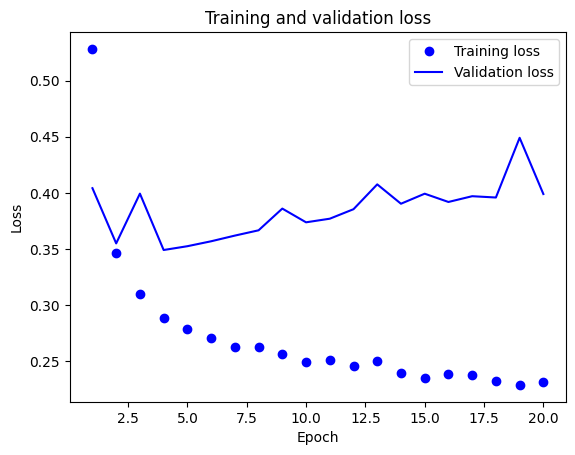

In [7]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

V praxi bývá mnohem spolehlivější třetí regularizační přístup - dropout. Jedná se o to, že se v rámci jednotlivých iterací trénování některé váhy dočasně vynulují (při predikci už ale žádné nulování není). V praxi se to celé realizuje přidáním *Dropout* vrstev. 

In [4]:
model_dropout = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_dropout.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model_dropout.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

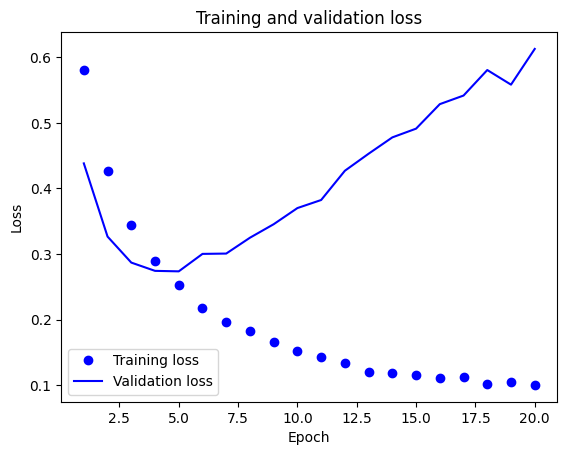

In [5]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Funkcionální API
Doposud jsme modely vyráběli tím nejjednodušším způsobem - skrz *keras.Sequential*, do jehož konstruktoru jsme vkládali list s vrstvami. Existuje ale i složítejší, avšak flexibilnější přístup - funkcionální API. Ukažme si, jak by tahle věc vypadala při vytváření IMDB modelu.  
Nejprve provedeme klasické načtení dat a jejich úpravu.

In [2]:
from tensorflow.keras.datasets import imdb
num_wanted_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_wanted_words)

def vectorize_sequence(semitransformed_reviews_array:np.ndarray, dimension:int=num_wanted_words):
    transformed_reviews_array = np.zeros(
        (
        len(semitransformed_reviews_array), 
        dimension
        )
    )
    for one_review_index, one_review in enumerate(semitransformed_reviews_array):
        for one_word_number in one_review:
            transformed_reviews_array[one_review_index,one_word_number] = 1
    return transformed_reviews_array

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

Nyní si vytvořme samotný model. Napřed musíme vytvořit v sekvenčním přístupu nepotřebnou vrstvu - Input (ona teda není nepotřebná, jen si ji v sekvenčím přístupu Keras dopočítá automaticky). V jejím konstruktoru musíme uvést parametr *shape* obsahující tuple s tvarem jednoho vzorku trénovacích dat. Tj. neuvádíme zde velikost batche. Pro "klasický" jednodimenzionální vstup bude *shape* roven (n,), kde n je počet featurů. V našem případě máme featurů 10 000, proto *shape=(10_000,)*. Pokud by vstupem byly barevné (tj. tříchannelové) obrázky 32x32 pixelů, psali bychom *shape=(32,32,3)*. Čárka v 1D variantě je z toho důvodu, že bez ní by Python z jednočlenného tuplu udělal rovnou integer, s čímž by si Keras neporadil.  
Následně za sebe jednotlivé vrstvy pokládáme, takže to vypadá, jako by ranější vrtva byla argumentem následující vrstvy. Nakonec vytvoříme *Model* objekt, u kterého specifikujeme, co je *inputs* a co je *outputs*.  
Pozn.: na funkcionální přístup to není nijak exkluzivně napojené, ale někde to zmínit musím - vrstvy můžeme pojmenovat s pomocí parametru *name* v konstruktoru.

In [10]:
inputs = keras.Input(shape=(10_000,))
my_first_layer = layers.Dense(16, activation="relu")(inputs)
my_second_layer = layers.Dense(16, activation="relu", name="moje_druha_vrstva")(my_first_layer)
outputs = layers.Dense(1, activation="sigmoid")(my_second_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

Trénování modelu je totožné jako u sekvenčního přístupu.

In [11]:
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

Stejně jako u sekvennčího přístupu si lze pomocí *summary* metody vypsat, jak neuronová síť vypadá a kolik má parametrů. U vrstev vidíme zda jak naše pojmenovávání, tak jména defaultní. None na prvních místech output shapu znamená, že se tahle věc může měnit. Zde konkrétně v závislosti na velikosti batche.

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                160016    
                                                                 
 moje_druha_vrstva (Dense)   (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Modely lze vizualizovat i do grafů, které se pak uloží do souboru. Člověk ale musí mít nainstalovaný graphviz (myšleno program, ne pythoní balíček) a balíček pydot.
```
keras.utils.plot_model(model, "graf_meho_modelu.jpg", show_shapes=True)
```

Lze mít i model s více vstupy (myšleno opravdu kvalitativně odlišnými, nikoli jen o jeden feature víc) a/nebo výstupy. Funguje to tak, že si vytvoříme několik *Input* vrstev, které slijeme dohromady s pomocí kódu ala
```
feature_layer = layers.Concatenate()([first_input, second_input, third_input])
```
A pro více výstupů
```
binary_output = layers.Dense(1, activation="sigmoid")(some_layer)
multiclass_output = layers.Dense(number_of_classes, activation="softmax")(some_layer)
```
Model se pak vytváří s pomocí
```
model = keras.Model(inputs=[first_input, second_input, third_input], outputs=[binary_output, multiclass_output])
```

## Callbacky a Tensorboard

Callbacky představují třídy, jejichž metody jsou spuštěny v určitých význačných okamžicích, např. na začátku/konci epochy či zpracování jedné batche. Člověk si může napsat i callbacky vlastní, my se tu ale podíváme na callbacky předpřipravené. *EarlyStopping* zastaví trénování, pakliže se specifikovaná metrika (v příkladu níže validační ztráta) nebude zlepšovat po dobu X epoch, kde X specifikujeme parametrem *patience*. *ModelCheckpoint* dovoluje ukládat iterace modelu během trénování; pokud použijeme *save_best_only* s hodnotou True, tak se uloží (přepíše uložení z předchozích epoch) jen takový model, jehož metrika specifikovaná v parametru *monitor* se zlepšila. *CSVLogger* na konci každé epochy zapíše sledované metriky do souboru.  
Ukažme si příklad na IMDB úloze. Vidíme, že list s callbacky se vkládá až do metody *fit*.

In [2]:
from tensorflow.keras.datasets import imdb
num_wanted_words = 10_000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_wanted_words)

def vectorize_sequence(semitransformed_reviews_array:np.ndarray, dimension:int=num_wanted_words):
    transformed_reviews_array = np.zeros(
        (
        len(semitransformed_reviews_array), 
        dimension
        )
    )
    for one_review_index, one_review in enumerate(semitransformed_reviews_array):
        for one_word_number in one_review:
            transformed_reviews_array[one_review_index,one_word_number] = 1
    return transformed_reviews_array

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

In [4]:
inputs = keras.Input(shape=(10_000,))
my_first_layer = layers.Dense(16, activation="relu")(inputs)
my_second_layer = layers.Dense(16, activation="relu", name="moje_druha_vrstva")(my_first_layer)
outputs = layers.Dense(1, activation="sigmoid")(my_second_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

In [5]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2
)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="imdb_model.keras",
    monitor="val_loss",
    save_best_only=True
)

csv_logger_callback = keras.callbacks.CSVLogger(
    "training_log.csv",
    separator="|", 
    append=False
)

callbacks_list = [
    early_stopping_callback, 
    model_checkpoint_callback, 
    csv_logger_callback
]

model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0,
    callbacks=callbacks_list
)

Model uložený pomocí callbacku (anebo třeba i normální metodou *save*) načteme funkcí *load_model*:

In [6]:
from tensorflow.keras.models import load_model

loaded_model = load_model("imdb_model.keras")
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                160016    
                                                                 
 moje_druha_vrstva (Dense)   (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Pokud se chceme podívat na grafy závislostí jednotlivých metrik na epoše, použijeme TensorBoard. Napřed do modelu vložíme odpovídající callback s adresářem, kam se mají logy ukládat (nemusí předem existovat).

In [7]:
inputs = keras.Input(shape=(10_000,))
my_first_layer = layers.Dense(16, activation="relu")(inputs)
my_second_layer = layers.Dense(16, activation="relu", name="moje_druha_vrstva")(my_first_layer)
outputs = layers.Dense(1, activation="sigmoid")(my_second_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)

tensorborad_callback = keras.callbacks.TensorBoard(
    log_dir="my_tensorboard_logs"
)

model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    verbose=0,
    callbacks=[tensorborad_callback]
)

Tensorboard samotný coby webovou aplikaci pak pustíme příkazem
```
tensorboard --logdir my_tensorboard_logs
```

# Časové řady
Data - časové řady o počasí z meteorologické stanice v Jeně - stáhneme [odsud](s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip).

In [31]:
import pandas as pd

In [2]:
temperatures_frame = pd.read_csv("jena_time_series\\jena_climate_2009_2016.csv")
temperatures_frame.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Vytvoříme si jednak separátní sérii s teplotami a jednak dataframe se vším (vč. teploty - teplota pro čas X závisí na teplotách předchozích) až na "date time" sloupec.

In [3]:
target_column_name = "T (degC)"
raw_data_columns_names = temperatures_frame.columns[1:]

target_column = temperatures_frame[target_column_name]
raw_data_columns = temperatures_frame[raw_data_columns_names]

Jelikož chceme predikovat časovou řadu (tj. chceme predikovat speciální časové období - budoucnost), nemůžeme data do trénovací, validační a testovací sady brát náhodně, nýbrž je musíme brát popořadě.

In [4]:
num_train_samples = int(0.50 * len(temperatures_frame))
num_val_samples = int(0.25 * len(temperatures_frame))
num_test_samples = len(temperatures_frame) - num_train_samples - num_val_samples

print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


Vzhledem k nesouměřitelným hodnotám ve sloupcích je musíme naškálovat.

In [5]:
train_data_mean = raw_data_columns[:num_train_samples].mean()
train_data_std = raw_data_columns[:num_train_samples].std()

raw_data_scaled = (raw_data_columns - train_data_mean) / train_data_std
raw_data_scaled.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.913649,-1.920636,-1.974488,-1.866254,1.048015,-1.291316,-1.467152,-0.782343,-1.470122,-1.472032,2.124151,-0.730165,-0.779351,-0.281192
1,0.919528,-1.965100,-2.018478,-1.919925,1.054028,-1.304472,-1.488855,-0.784440,-1.489114,-1.493462,2.172914,-0.932305,-0.886968,-0.469893
2,0.914825,-1.976501,-2.029758,-1.924162,1.084097,-1.307103,-1.491266,-0.786537,-1.492912,-1.495843,2.183381,-1.277899,-1.261473,-0.056383
3,0.912474,-1.953699,-2.006071,-1.890265,1.102138,-1.300525,-1.476798,-0.788633,-1.477719,-1.481556,2.158404,-1.180089,-1.317434,0.251128
4,0.912474,-1.949139,-2.002687,-1.886027,1.096124,-1.299210,-1.474386,-0.788633,-1.477719,-1.479175,2.153885,-1.193130,-1.261473,0.440993


Pro přípravu dat pro trénování modelu na časové řady se hodí funkce *timeseries_dataset_from_array*. Pro pochopení jejích parametrů si napřed vytvořme fake data.

In [7]:
fake_features = range(1,101)
fake_target = range(8, 109)

Funkci musíme nakrmit minimálně třemi parametry. Jednak featurami, jednak targetem a jednak *sequence_length*. Ta udává, jak dlouhý výsek featur se má vzít pro vytvoření jednoho záznamu.

In [17]:
fake_dataset = keras.utils.timeseries_dataset_from_array(
    fake_features,
    fake_target,
    sequence_length=10
)

Zdůrazněme, že výseky se překrývají (tj. není to tak, že by jeden končil desítkou a druhý začínal jedenáctkou).

In [18]:
for fake_dataset_features, fake_dataset_target in fake_dataset:
    print(fake_dataset_features[0:5])
    print(fake_dataset_target[0:5])
    print("************")

tf.Tensor(
[[ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]], shape=(5, 10), dtype=int32)
tf.Tensor([ 8  9 10 11 12], shape=(5,), dtype=int32)
************


Parametr *sampling_rate* zařídí, že se při konstrukci feature vektorů bude brát jen každy N-tý záznam (targety nijak posouvané nejsou). Defaultně *sampling_rate* = 1.

In [19]:
fake_dataset = keras.utils.timeseries_dataset_from_array(
    fake_features,
    fake_target,
    sequence_length=10,
    sampling_rate=5
)

for fake_dataset_features, fake_dataset_target in fake_dataset:
    print(fake_dataset_features[0:5])
    print(fake_dataset_target[0:5])
    print("************")

tf.Tensor(
[[ 1  6 11 16 21 26 31 36 41 46]
 [ 2  7 12 17 22 27 32 37 42 47]
 [ 3  8 13 18 23 28 33 38 43 48]
 [ 4  9 14 19 24 29 34 39 44 49]
 [ 5 10 15 20 25 30 35 40 45 50]], shape=(5, 10), dtype=int32)
tf.Tensor([ 8  9 10 11 12], shape=(5,), dtype=int32)
************


Parametry *start_index* a *end_index* způsobí, že se z dat (jak featurů, tak targetů) budou brát jen hodnoty mezi těmito indexy. Pokud si jsou tyto čísla blíž než je *sequence_length*, tak ve vytvořeném datasetu nebude nic.

In [24]:
fake_dataset = keras.utils.timeseries_dataset_from_array(
    fake_features,
    fake_target,
    sequence_length=10,
    start_index=3,
    end_index=15
)

for fake_dataset_features, fake_dataset_target in fake_dataset:
    print(fake_dataset_features[0:5])
    print(fake_dataset_target[0:5])
    print("************")

tf.Tensor(
[[ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]], shape=(3, 10), dtype=int32)
tf.Tensor([11 12 13], shape=(3,), dtype=int32)
************


Pokud nastavíme *shuffle*=True (defaultně False), bude dataset poskytovat záznamy nikoli chronologicky, ale náhodně.

In [25]:
fake_dataset = keras.utils.timeseries_dataset_from_array(
    fake_features,
    fake_target,
    sequence_length=10,
    shuffle=True
)

for fake_dataset_features, fake_dataset_target in fake_dataset:
    print(fake_dataset_features[0:5])
    print(fake_dataset_target[0:5])
    print("************")

tf.Tensor(
[[80 81 82 83 84 85 86 87 88 89]
 [39 40 41 42 43 44 45 46 47 48]
 [74 75 76 77 78 79 80 81 82 83]
 [55 56 57 58 59 60 61 62 63 64]
 [29 30 31 32 33 34 35 36 37 38]], shape=(5, 10), dtype=int32)
tf.Tensor([87 46 81 62 36], shape=(5,), dtype=int32)
************


Nakonec parametrem *batch_size* nastavíme počet záznamů v každé dávce (defaultně 128).

In [29]:
fake_dataset = keras.utils.timeseries_dataset_from_array(
    fake_features,
    fake_target,
    sequence_length=10,
    batch_size=2
)

for fake_dataset_features, fake_dataset_target in fake_dataset:
    print(fake_dataset_features)
    print(fake_dataset_target)
    print("************")
    break

tf.Tensor(
[[ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]], shape=(2, 10), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)
************


Vytvořme si tedy datasety pro trénování, validaci a test. V datech máme pro každou hodinu 6 záznamů (měření po 10 minutách), tudíž *sampling_rate*=6 budeme mít jeden záznam na hodinu. Delay se v indexování vstupních framů objevuje proto, aby bylo z *raw_data_scaled* do featurů bráno vše až na posledních *delay* záznamů a naopak do targetů šly až teploty pro ony vynechané záznamy. 

In [6]:
sampling_rate = 6
sequence_length = 5*24
delay = sampling_rate*(sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data_scaled[:-delay],
    targets=target_column[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data_scaled[:-delay],
    targets=target_column[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data_scaled[:-delay],
    targets=target_column[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples
)

In [7]:
input_frame_col_count = raw_data_scaled.shape[-1]
inputs = keras.Input(shape=(sequence_length, input_frame_col_count))
lstm_layer = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(lstm_layer)
simple_model = keras.Model(inputs, outputs)
simple_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = simple_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=False
)

MAE má vcelku rozumno velikost, z grafu ale vidíme, že došlo k overfitingu.

In [8]:
print(f"Test MAE: {simple_model.evaluate(test_dataset)[1]}")

405/405 [==============================] - 9s 22ms/step - loss: 10.9568 - mae: 2.5573
Test MAE: 2.5572612285614014


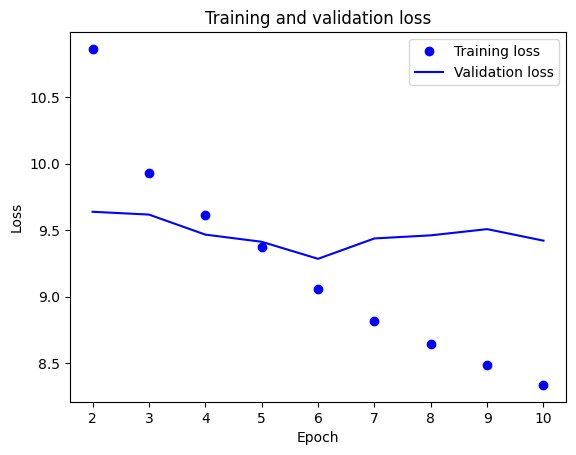

In [11]:
history_dict = history.history
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(2, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values[1:], "bo", label="Training loss")
plt.plot(epochs, val_loss_values[1:], "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Abychom overiftingu zabránili, použijeme dropout. S ním se ale pracuje trochu jinak než dejme tomu u konvolučních sítí - krom dedikované dropout vrstvy musíme ještě přidat odpovídající parametr do LSTM vrstev. Též je třeba do všech rekurentních vrstev s výjimkou té poslední dodat parametr *return_sequences* s hodnotou True (defaultní je False). False povede k tomu, že se vrátí poslední člen výstupní sekvence (myšleno člen s "nejvyšším" časem), True, že se vrátí sekvence celá - bez toho by na sebe rekurentní vrstvy nešlo lepit.

In [ ]:
input_frame_col_count = raw_data_scaled.shape[-1]
inputs = keras.Input(shape=(sequence_length, input_frame_col_count))
lstm_layer_1 = layers.LSTM(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
lstm_layer_2 = layers.LSTM(16, recurrent_dropout=0.5, return_sequences=False)(lstm_layer_1)
dropout_layer = layers.Dropout(0.5)(lstm_layer_2)
outputs = layers.Dense(1)(dropout_layer)
dropout_model = keras.Model(inputs, outputs)
dropout_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = dropout_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=True
)